# Real M1 annual growth with Hong Kong recessions 

This script downloads Hong Kong government produced statistics for money supply, composite consumer price index (cpi), nominal gross domestic product (gdp) statistics and the gdp deflator. It puts these data onto a common quarterly basis and computes inflation adjusted "real" annual growth for each variable. 

The source for monthly money supply is the Hong Kong Monetary Authority. The source for the monthly cpi, quarterly gdp and gdp deflator is the Hong Kong census and statistics department. For each series the data is downloaded from each department's application program interface (API). 

Because the money supply is month end data we have taken the end month that corresponds to the quarter to convert the monthly series to a quarterly series. And have treated the corresponding cpi index in the same way. The result of that is to match up the money supply and cpi time series to the quarterly gdp and gdp deflator time series. Once the data are aligned by date the nominal time series are deflated by the composite cpi ratio for money supply and by the gdp deflator for gdp. Once these "real time series" are obtained the annual change for each quarter is generated. 

A chart is plotted to show real M1 annual growth with Hong Kong recessions to examine whether a leading relationship exists in these variables as has been found in other markets and for instance in the EU (see 'The predictive power of real M1 for real economic activity in the euro area', Prepared by [Alberto Musso, European Central bank Economic Bulletin, Issue 3, 2019, page 35](https://www.ecb.europa.eu/pub/pdf/ecbu/eb201903.en.pdf), accessed: 2024-03-04)

Some brief statistics tests are performed to examine the nature of the relationship in the Hong Kong context. Let us get started.

In [2]:
import requests
import json
import urllib.request
import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches # add shaded part as legend
!pip install statsmodels
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

We first download the monthly [Money supply – Unadjusted for foreign currency swap deposits](https://apidocs.hkma.gov.hk/documentation/market-data-and-statistics/monthly-statistical-bulletin/money/supply-unadjusted-fc/) from the Hong Kong Monetary Authority website. And add the pagesize of 1000 to gather all the historic data in the timeseries and set the date column to be month end dates. 

In [5]:
url = 'https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/money/supply-unadjusted-fc?pagesize=1000'

response = requests.get(url)
data = response.json()

if 'result' in data and 'records' in data['result']:
    records = data['result']['records']
else:
    print("The key 'result' or 'records' does not exist in the data.")
    records = []

# put in a dataframe 
df_moneysupply = pd.DataFrame(records)

# keep columns end_of_month, m1_total, m2_total
df_moneysupply = df_moneysupply[['end_of_month', 'm1_total', 'm2_total']]

# rename end_of_month to date
df_moneysupply = df_moneysupply.rename(columns={'end_of_month': 'date'})

# convert date to datetime from YYYY-MM format to YYYY-MM-DD using end of month date
df_moneysupply['date'] = pd.to_datetime(df_moneysupply['date'], format='%Y-%m') + pd.offsets.MonthEnd(1)

# sort the dataframe based on date in ascending order
df_moneysupply = df_moneysupply.sort_values(by='date')

# describe m2 and m1 and quaid money
print(df_moneysupply.info)


<bound method DataFrame.info of           date     m1_total      m2_total
320 1997-04-30   226780.282  2.722283e+06
319 1997-05-31   226089.335  2.760299e+06
318 1997-06-30   226855.099  2.784347e+06
317 1997-07-31   228037.575  2.806834e+06
316 1997-08-31   221188.897  2.791558e+06
..         ...          ...           ...
4   2023-08-31  2605772.523  1.679123e+07
3   2023-09-30  2502110.929  1.678574e+07
2   2023-10-31  2559041.178  1.679603e+07
1   2023-11-30  2619737.341  1.705916e+07
0   2023-12-31  2598202.612  1.719527e+07

[321 rows x 3 columns]>


The monthly composite consumer price is obtained from [Table 510-60001 : Consumer Price Indices (October 2019 – September 2020 = 100)](https://www.censtatd.gov.hk/en/web_table.html?id=510-60001#) from the census and statistics website.

In [7]:
url = "https://www.censtatd.gov.hk/api/post.php"
parameters ={
  "cv": {},
  "sv": {
    "CC_CM_1920": [
      "Raw_1dp_idx_n"
    ]
  },
  "period": {
    "start": "197407"
  },
  "id": "510-60001",
  "lang": "en"
}
data = {'query': json.dumps(parameters)}

try:
    r = requests.post(url, data=data, timeout=20)
    r.raise_for_status()  # Raise an exception if the request was unsuccessful
except (requests.exceptions.HTTPError, requests.exceptions.RequestException) as err:
    print(f"An error occurred: {err}")
else:
    response_data = r.json()
    if response_data['header']['status']['name'] == 'Success':
        if response_data['dataSet']:
            df_cpi = pd.DataFrame(response_data['dataSet'])
            #print(df_cpi)
        else:
            print("No data available")
    else:
        print(f"Request failed: {response_data['header']['status']['description']}")

# from the dataframe remove all rows that do not contain "M" in the freq column
df_cpi = df_cpi[df_cpi['freq'].str.contains('M')]

# keep wanted columns period and figure
df_cpi = df_cpi[['period', 'figure']]

# rename the period column "date" and make a datetime format from YYYYMM to YYYY-MM-DD with month end date
df_cpi = df_cpi.rename(columns={'period': 'date'})
df_cpi['date'] = pd.to_datetime(df_cpi['date'], format='%Y%m') + pd.offsets.MonthEnd(1)
                                
# sort the dataframe based on date in ascending order
df_cpi = df_cpi.sort_values(by='date')

# rename figure column to GDP_at_current_prices
df_cpi = df_cpi.rename(columns={'figure': 'CPI_composite_index_yr2019oct_sept2020_100'})

# print the dataframe
print(df_cpi)

          date CPI_composite_index_yr2019oct_sept2020_100
3   1974-07-31                                           
4   1974-08-31                                           
5   1974-09-30                                           
0   1974-10-31                                           
1   1974-11-30                                           
..         ...                                        ...
642 2023-09-30                                      105.6
632 2023-10-31                                      106.7
633 2023-11-30                                      106.6
634 2023-12-31                                      106.7
643 2024-01-31                                      106.6

[595 rows x 2 columns]


The money supply and consumer price index dataframes were then merged into one. And the monthly time series were converted to quarters. 

In [9]:
# merge money supply data and cpi deflator
df_merged_money = pd.merge(df_moneysupply, df_cpi, on='date')

# make date column datetime format YYYY-MM-DD
df_merged_money['date'] = pd.to_datetime(df_merged_money['date'])

# sort dataframe on date column in ascending order
df_merged_money = df_merged_money.sort_values(by='date', ascending=True)

# resample to quarterly

# set date as the index
df_merged_money.set_index('date', inplace=True)

# resample to quarterly data by taking the last value of each quarter
quarterly_end_of_period_money_cpi_index = df_merged_money.resample('Q').last()

#print
print(quarterly_end_of_period_money_cpi_index)

               m1_total      m2_total  \
date                                    
1997-06-30   226855.099  2.784347e+06   
1997-09-30   223655.827  2.846131e+06   
1997-12-31   208092.943  2.788808e+06   
1998-03-31   201920.784  2.872865e+06   
1998-06-30   188211.687  2.847062e+06   
...                 ...           ...   
2022-12-31  2769343.469  1.653608e+07   
2023-03-31  2712677.622  1.661968e+07   
2023-06-30  2582311.860  1.655257e+07   
2023-09-30  2502110.929  1.678574e+07   
2023-12-31  2598202.612  1.719527e+07   

            CPI_composite_index_yr2019oct_sept2020_100  
date                                                    
1997-06-30                                        74.4  
1997-09-30                                        75.4  
1997-12-31                                        76.2  
1998-03-31                                        76.7  
1998-06-30                                        77.4  
...                                                ...  
2022-12-31

Quarterly GDP data was downloaded from the census and statistics department from [Table 310-31002 : Gross Domestic Product (GDP) by major expenditure component at current market prices](https://www.censtatd.gov.hk/en/web_table.html?id=310-31002). 

In [12]:
url = "https://www.censtatd.gov.hk/api/post.php"
parameters ={
  "cv": {
    "GDP_COMPONENT": [
      "FD",
      "DD",
      "PCE",
      "GCE",
      "GDFCF",
      "CIV",
      "XGS",
      "MGS",
      "XG",
      "XS",
      "MG",
      "MS"
    ]
  },
  "sv": {
    "CUR": [
      "Raw_M_hkd_d"
    ]
  },
  "period": {
    "start": "197301"
  },
  "id": "310-31002",
  "lang": "en"
}
data = {'query': json.dumps(parameters)}

try:
    r = requests.post(url, data=data, timeout=20)
    r.raise_for_status()  # Raise an exception if the request was unsuccessful
except (requests.exceptions.HTTPError, requests.exceptions.RequestException) as err:
    print(f"An error occurred: {err}")
else:
    response_data = r.json()
    if response_data['header']['status']['name'] == 'Success':
        if response_data['dataSet']:
            df_gdp = pd.DataFrame(response_data['dataSet'])
            #print(df_gdp)
        else:
            print("No data available")
    else:
        print(f"Request failed: {response_data['header']['status']['description']}")

# from the dataframe remove all rows that do not contain "Total" in the GDP_COMPONTEDesc column
df_gdp = df_gdp[df_gdp['GDP_COMPONENTDesc'].str.contains('Total')]

# from the dataframe remove all rows that do not contain "Q" in the freq column
df_gdp = df_gdp[df_gdp['freq'].str.contains('Q')]

# keep wanted columns period and figure
df_gdp = df_gdp[['period', 'figure']]

# rename the period column "date" and make a datetime format from YYYYMM to YYYY-MM-DD
df_gdp = df_gdp.rename(columns={'period': 'date'})
df_gdp['date'] = pd.to_datetime(df_gdp['date'], format='%Y%m')+ pd.offsets.MonthEnd(1)

# rename figure column to GDP_at_current_prices
df_gdp = df_gdp.rename(columns={'figure': 'GDP_at_current_prices_HKDMillions'})

print(df_gdp)

           date  GDP_at_current_prices_HKDMillions
13   1973-03-31                               9697
26   1973-06-30                               9586
39   1973-09-30                              10979
52   1973-12-31                              11064
78   1974-03-31                              11664
...         ...                                ...
3237 2022-12-31                             732062
3263 2023-03-31                             720760
3276 2023-06-30                             707502
3289 2023-09-30                             768426
3302 2023-12-31                             794640

[204 rows x 2 columns]


Quarterly gdp deflator data was from [Table 310-31001 : Gross Domestic Product (GDP), implicit price deflator of GDP and per capita GDP](https://www.censtatd.gov.hk/en/web_table.html?id=31).

In [13]:
url = "https://www.censtatd.gov.hk/api/post.php"
parameters ={
  "cv": {},
  "sv": {
    "DEF": [
      "Raw_1dp_idx_n"
    ]
  },
  "period": {
    "start": "197301"
  },
  "id": "310-31001",
  "lang": "en"
}
data = {'query': json.dumps(parameters)}

try:
    r = requests.post(url, data=data, timeout=20)
    r.raise_for_status()  # Raise an exception if the request was unsuccessful
except (requests.exceptions.HTTPError, requests.exceptions.RequestException) as err:
    print(f"An error occurred: {err}")
else:
    response_data = r.json()
    if response_data['header']['status']['name'] == 'Success':
        if response_data['dataSet']:
            df_deflator = pd.DataFrame(response_data['dataSet'])
            #print(df_deflator)
        else:
            print("No data available")
    else:
        print(f"Request failed: {response_data['header']['status']['description']}")

# from the dataframe remove all rows that do not contain "Q" in the freq column
df_deflator = df_deflator[df_deflator['freq'].str.contains('Q')]

# keep wanted columns period and figure
df_deflator = df_deflator[['period', 'figure']]

# rename the period column "date" and make a datetime format from YYYYMM to YYYY-MM-DD
df_deflator = df_deflator.rename(columns={'period': 'date'})
df_deflator['date'] = pd.to_datetime(df_deflator['date'], format='%Y%m')+ pd.offsets.MonthEnd(1)

# rename figure column to GDP_at_current_prices
df_deflator = df_deflator.rename(columns={'figure': 'GDP_deflator_index_yr2021_100'})

# print 
print(df_deflator)


          date  GDP_deflator_index_yr2021_100
1   1973-03-31                           12.7
2   1973-06-30                           12.7
3   1973-09-30                           13.6
4   1973-12-31                           14.2
6   1974-03-31                           14.4
..         ...                            ...
249 2022-12-31                          101.8
251 2023-03-31                          103.2
252 2023-06-30                          103.8
253 2023-09-30                          106.5
254 2023-12-31                          106.0

[204 rows x 2 columns]


We then merged the quarterly GDP and GDP deflator time series. 

In [15]:
# merge money supply data and cpi deflator
df_merged_gdp_def = pd.merge(df_gdp, df_deflator, on='date')

# make date column datetime format YYYY-MM-DD
df_merged_gdp_def['date'] = pd.to_datetime(df_merged_gdp_def['date'])

# sort dataframe on date column in ascending order
df_merged_gdp_def = df_merged_gdp_def.sort_values(by='date', ascending=True)

# set date as the index
df_merged_gdp_def.set_index('date', inplace=True)

#print
print(df_merged_gdp_def)

            GDP_at_current_prices_HKDMillions  GDP_deflator_index_yr2021_100
date                                                                        
1973-03-31                               9697                           12.7
1973-06-30                               9586                           12.7
1973-09-30                              10979                           13.6
1973-12-31                              11064                           14.2
1974-03-31                              11664                           14.4
...                                       ...                            ...
2022-12-31                             732062                          101.8
2023-03-31                             720760                          103.2
2023-06-30                             707502                          103.8
2023-09-30                             768426                          106.5
2023-12-31                             794640                          106.0

And then merged the money supply and cpi together to the gdp and gdp deflator dataframes.

In [17]:
# 7. merge quarterly_end_of_period_money_cpi_index and df_merged_gdp_def on index

df_merged = pd.merge(quarterly_end_of_period_money_cpi_index, df_merged_gdp_def, on='date')


Once the data was in one dataframe we computed the real inflation adjusted money supply for M1 and M2 using the cpi index and real gdp using the gdp deflator index. And the year on year annual change in money supply M1 and M2 and gdp.  

In [27]:
# compute the CPI composite deflator index ratio using the formula calculate the ratio of the price index in 2019-10-31 through 2020-09-302021-12-31 to the price index in the current period.
# create a fresh column called gdp_deflator_ratio and make it 100/'GDP_deflator_index_yr2021_100'
df_merged['cpi_composite_deflator_ratio'] = 100 / df_merged['CPI_composite_index_yr2019oct_sept2020_100']

# create a real_M1 column that is m1_total * cpi_composite_deflator_ratio
df_merged['real_m1'] = df_merged['m1_total'] * df_merged['cpi_composite_deflator_ratio']

# create a real_M2 column that is m2_total * cpi_composite_deflator_ratio
df_merged['real_m2'] = df_merged['m2_total'] * df_merged['cpi_composite_deflator_ratio']

# create columns that compute the year on year percentage change of GDP and real GDP
# we use the formula ((current quarter - previous quarter) / previous quarter) * 100
df_merged['real_m1_yoy'] = ((df_merged['real_m1'] / df_merged['real_m1'].shift(4))-1) * 100
df_merged['m1_yoy'] = ((df_merged['m1_total'] / df_merged['m1_total'].shift(4))-1) * 100

df_merged['real_m2_yoy'] = ((df_merged['real_m2'] / df_merged['real_m2'].shift(4))-1) * 100
df_merged['m2_yoy'] = ((df_merged['m2_total'] / df_merged['m2_total'].shift(4))-1) * 100

# compute the GDP deflator index ratio using the formula calculate the ratio of the price index in 2021-12-31 to the price index in the current period.
# create a fresh column called gdp_deflator_ratio and make it 100/'GDP_deflator_index_yr2021_100'
df_merged['gdp_deflator_ratio'] = 100 / df_merged['GDP_deflator_index_yr2021_100']

# create a real_GDP column that is GDP_at_current_prices_HKDMillions * gdp_deflator_ratio
df_merged['real_GDP'] = df_merged['GDP_at_current_prices_HKDMillions'] * df_merged['gdp_deflator_ratio']

# create columns that compute the year on year percentage change of GDP and real GDP
# the data is quarterly to ensure we are using the quarter from the previous year
# we use the formula ((current quarter - previous quarter) / previous quarter) * 100
df_merged['real_GDP_yoy'] = ((df_merged['real_GDP'] / df_merged['real_GDP'].shift(4))-1) * 100
df_merged['GDP_yoy'] = ((df_merged['GDP_at_current_prices_HKDMillions'] / df_merged['GDP_at_current_prices_HKDMillions'].shift(4))-1) * 100

# print date, real_m1_yoy and real_GDP_yoy
print(df_merged[['real_m1_yoy', 'real_GDP_yoy']])

            real_m1_yoy  real_GDP_yoy
date                                 
1997-06-30          NaN           NaN
1997-09-30          NaN           NaN
1997-12-31          NaN           NaN
1998-03-31          NaN           NaN
1998-06-30   -20.250124     -6.057252
...                 ...           ...
2022-12-31   -22.191358     -4.282775
2023-03-31   -25.264907      2.899293
2023-06-30   -23.676461      1.432652
2023-09-30   -19.233501      4.176343
2023-12-31    -8.378058      4.247217

[107 rows x 2 columns]


The script then generated the periods of past Hong Kong recessions that would be overlayed onto the chart of real M1 annual growth. 

In [28]:
# Assuming the recession starts after two consecutive quarters of negative real GDP YoY change
# and ends after two consecutive quarters of positive real GDP YoY change after it has started.
# We will create lists to hold the start and end dates of recessions
recession_starts = []
recession_ends = []
in_recession = False

# Reset the DataFrame's index
df_merged = df_merged.reset_index()

# Loop through the DataFrame to identify the start and end dates
for i in range(1, len(df_merged)):
    if not in_recession and df_merged.loc[i-1, 'real_GDP_yoy'] < 0 and df_merged.loc[i, 'real_GDP_yoy'] < 0:
        recession_starts.append(df_merged.loc[i, 'date'])
        in_recession = True
    elif in_recession and df_merged.loc[i-1, 'real_GDP_yoy'] >= 0 and df_merged.loc[i, 'real_GDP_yoy'] >= 0:
        recession_ends.append(df_merged.loc[i-1, 'date'])
        in_recession = False

# Handling the case where the last period in the data is still in a recession
if in_recession:
    recession_ends.append(df_merged.loc[len(df_merged)-1, 'date'])

Chart plotted

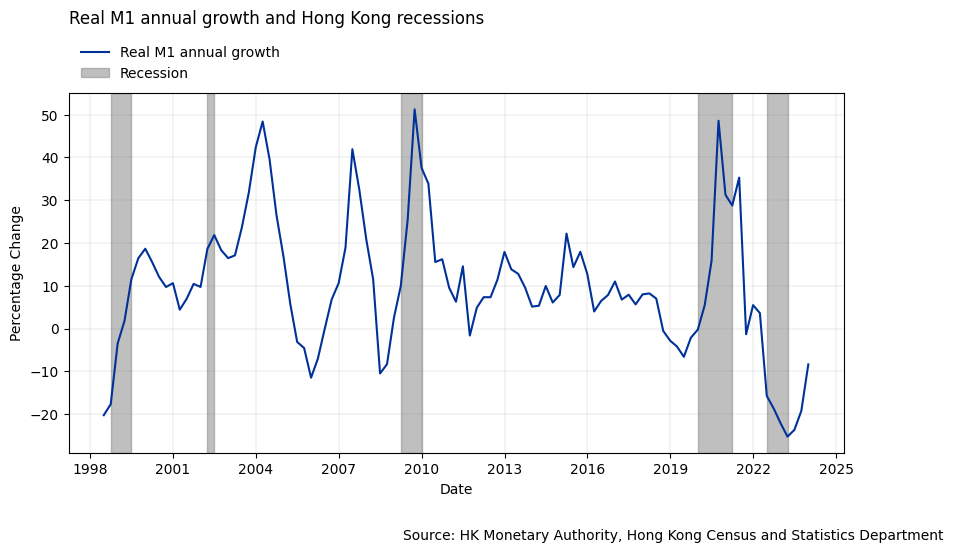

In [30]:
# Ensure 'date' column is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Now plot your charts with the recession periods highlighted
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(df_merged['date'], df_merged['real_m1_yoy'], label='Real M1 annual growth', color='#003199')
# Use the `pad` argument to add some space between the title and the plot
ax2.set_title('Real M1 annual growth and Hong Kong recessions', pad=50, loc='left')
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage Change')

# Shade the periods of recession
for start, end in zip(recession_starts, recession_ends):
    ax2.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.5)

# Create a patch for the legend representing recessions
recession_patch = mpatches.Patch(color='grey', alpha=0.5, label='Recession')

# Set major ticks on the x-axis to 3 years intervals
ax2.xaxis.set_major_locator(mdates.YearLocator(base=3))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Get handles and labels for the legend from the plot
handles, labels = ax2.get_legend_handles_labels()
# Add the recession patch to the handles for the legend
handles.append(recession_patch)
labels.append('Recession')

# Adjust the figure to fit the legend and the title
plt.subplots_adjust(top=0.75, bottom=0.15)

# Use fig.legend() to place the legend below the title and to the left
# Adjust the bbox_to_anchor y-value to lower the legend
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.125, 0.85), frameon=False, ncol=1)

# Add source to the chart
source_text = "Source: HK Monetary Authority, Hong Kong Census and Statistics Department"
fig.text(1, 0, source_text, ha='right', va='bottom')

plt.show()

A close examination of the chart will take place at a different time when a fuller appraisal of economic and monetary conditions is undertaken. But in terms of the past two recessions there appears to be a deceleration in narrow m1 growth ahead of the recession. And then once in the recession the change in narrow money seems to advance ahead of the recession ending. That being said the relationship appears less clear for the 2009 recession. More encouragingly perhaps is the recent abatement in the contraction in narrow money growth.

In [42]:
# Initialize the columns for recession start and end dates with NaN
df_merged['recession_start'] = pd.NaT
df_merged['recession_end'] = pd.NaT

# We will use a flag to mark the ongoing recession status
in_recession = False

# Loop through the DataFrame to identify the start and end dates
for i in range(1, len(df_merged)):
    # Check for the start of a recession
    if not in_recession and df_merged.loc[i-1, 'real_GDP_yoy'] < 0 and df_merged.loc[i, 'real_GDP_yoy'] < 0:
        df_merged.at[i, 'recession_start'] = df_merged.loc[i, 'date']
        in_recession = True
    # Check for the end of a recession
    elif in_recession and df_merged.loc[i-1, 'real_GDP_yoy'] >= 0 and df_merged.loc[i, 'real_GDP_yoy'] >= 0:
        df_merged.at[i-1, 'recession_end'] = df_merged.loc[i-1, 'date']
        in_recession = False

# Handling the case where the last period in the data is still in a recession
if in_recession:
    df_merged.at[len(df_merged)-1, 'recession_end'] = df_merged.loc[len(df_merged)-1, 'date']

# Print the rows where recessions start or end for verification
print(df_merged.dropna(subset=['recession_start', 'recession_end'], how='all')[['date', 'recession_start', 'recession_end']])

          date recession_start recession_end
5   1998-09-30      1998-09-30           NaT
8   1999-06-30             NaT    1999-06-30
19  2002-03-31      2002-03-31           NaT
20  2002-06-30             NaT    2002-06-30
47  2009-03-31      2009-03-31           NaT
50  2009-12-31             NaT    2009-12-31
90  2019-12-31      2019-12-31           NaT
95  2021-03-31             NaT    2021-03-31
100 2022-06-30      2022-06-30           NaT
103 2023-03-31             NaT    2023-03-31


Several statistical tests are performed on the real change in narrow money and gdp series to examine the relationship between the two series. The tests run were: Granger causality test; Augmented Dickey-Fuller test for stationarity; and, a test for cointegration. In the first case it was found that at the significance level of 0.05 there appears to be a leading relationship between the change in real money (variable 1) and the change in real gdp that was especially strong at three quarters but also significant at one and two quarters. The Augmented Dickey-Fuller test however showed that both series were non stationary. And there appeared little cointegration between the two series suggesting little evidence of a long run relationship between the two variables. 

In [43]:
# Combine into a DataFrame
data = df_merged[['date', 'real_m1_yoy', 'real_GDP_yoy']]

# Drop rows with NaN values
data = data.dropna()

# print
print(data)

# Perform Granger causality test 
max_lag = 5
test_result = grangercausalitytests(data[['real_GDP_yoy', 'real_m1_yoy']], max_lag)


          date  real_m1_yoy  real_GDP_yoy
4   1998-06-30   -20.250124     -6.057252
5   1998-09-30   -17.687111     -8.324043
6   1998-12-31    -3.490795     -6.256604
7   1999-03-31     1.783722     -3.061391
8   1999-06-30    11.517173      0.478816
..         ...          ...           ...
102 2022-12-31   -22.191358     -4.282775
103 2023-03-31   -25.264907      2.899293
104 2023-06-30   -23.676461      1.432652
105 2023-09-30   -19.233501      4.176343
106 2023-12-31    -8.378058      4.247217

[103 rows x 3 columns]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.9549 , p=0.0005  , df_denom=99, df_num=1
ssr based chi2 test:   chi2=13.3475 , p=0.0003  , df=1
likelihood ratio test: chi2=12.5436 , p=0.0004  , df=1
parameter F test:         F=12.9549 , p=0.0005  , df_denom=99, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9005  , p=0.0038  , df_denom=96, df_num=2
ssr based chi2 test:   chi2=12.4156 , p=0.0020  , df=2

In [44]:
def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test on a time series to assess its stationarity
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')  # Let the test choose the best lag
    labels = ['ADF test statistic', 'p-value', '# lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'Critical value ({key})'] = value
    print(out.to_string())  # Print the results
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary ")

# Apply the ADF test on each variable
adf_test(data['real_m1_yoy'], 'real_m1_yoy')
adf_test(data['real_GDP_yoy'], 'real_GDP_yoy')

Augmented Dickey-Fuller Test: real_m1_yoy
ADF test statistic        -2.104748
p-value                    0.242610
# lags used               13.000000
Number of observations    89.000000
Critical value (1%)       -3.506057
Critical value (5%)       -2.894607
Critical value (10%)      -2.584410
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary 
Augmented Dickey-Fuller Test: real_GDP_yoy
ADF test statistic        -1.543705
p-value                    0.511791
# lags used               12.000000
Number of observations    90.000000
Critical value (1%)       -3.505190
Critical value (5%)       -2.894232
Critical value (10%)      -2.584210
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary 


In [41]:
def perform_cointegration_test(variable1, variable2):
    """
    Perform Engle-Granger cointegration test on two time series.
    """
    coint_test_statistic, p_value, critical_values = coint(variable1, variable2)
    print("Cointegration test results:")
    print(f"Test statistic: {coint_test_statistic}")
    print(f"P-value: {p_value}")
    print("Critical values (1%, 5%, 10%):")
    print(f"  1%: {critical_values[0]}")
    print(f"  5%: {critical_values[1]}")
    print(f" 10%: {critical_values[2]}")
    
    if p_value < 0.05:
        print("There is evidence to reject the null hypothesis of no cointegration at the 5% significance level.")
        print("This suggests that there is a long-term equilibrium relationship between the two time series.")
    else:
        print("There is not enough evidence to reject the null hypothesis of no cointegration.")
        print("This suggests that the two time series do not have a long-term equilibrium relationship.")

# Perform the cointegration test on your time series data
perform_cointegration_test(data['real_m1_yoy'], data['real_GDP_yoy'])

Cointegration test results:
Test statistic: -3.2911542974204253
P-value: 0.05595994612676716
Critical values (1%, 5%, 10%):
  1%: -4.007034079200308
  5%: -3.3966887466359093
 10%: -3.0862918300653592
There is not enough evidence to reject the null hypothesis of no cointegration.
This suggests that the two time series do not have a long-term equilibrium relationship.
